# Gemini


In [2]:
import re
import tqdm
import keras
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv

import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold


import seaborn as sns
import matplotlib.pyplot as plt

from keras import layers
from matplotlib.ticker import MaxNLocator
from sklearn.datasets import fetch_20newsgroups
import sklearn.metrics as skmetrics

## Dataset

Se cargan los datasets de `training`, `validation` y `test` que se han utilizado en otros modelos para garantizar consistencia al momento de comparar los resultados. Cada uno de estos datasets contiene dos variables **text** y **emotion**


In [3]:
df_train = pd.read_csv("../data/data_to_model/train_data.csv")
df_val = pd.read_csv("../data/data_to_model/val_data.csv")
df_test = pd.read_csv("../data/data_to_model/test_data.csv")

In [4]:
df_train.head()

,text,emotion
0,when the week for exams came i got afraid as t...,fear
1,i was sleeping when i heard the neighbours scr...,fear
2,there was a time when my room looked terribly ...,shame
3,when my friend told me that he would come and ...,joy
4,"when i saw the film ""johnny got his gun"" which...",sadness


In [5]:
df_train.text[1]

"i was sleeping when i heard the neighbours screaming, i peeped through the window and saw a thief  trying to enter my neighbour's house"

## Gemini Client Configuration

En este paso se configura el cliente con el API Key previamente generada en https://aistudio.google.com/app/apikey

Es importante mencionar que el uso de esta API consume créditos (dinero), por lo tanto, no se hace pública y para reproducir el Notebook deben configurar su propia API Key en el archivo `.env` con el siguiente formato:

GEMINI_API = xxxxxxxxxxxx


In [6]:
load_dotenv()

True

In [7]:
genai.configure(api_key=os.getenv("GEMINI_API"))

## Modelos Disponibles

A la fecha de este desarrollo, se encuentran disponbiles los siguientes modelos con **salida de texto** :`Gemini 1.5-flash`, `Gemini 1.5-pro` y `gemini-1.0-pro` (https://ai.google.dev/gemini-api/docs/models/gemini?hl=es-419)


In [8]:
for m in genai.list_models():
    print(m.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro
models/gemini-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-pro-exp-0801
models/gemini-1.5-pro-exp-0827
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-exp-0827
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/embedding-001
models/text-embedding-004
models/aqa


## Transfer Learning

Los LLM han sido entrenados con enormes volumenes de datos y han guardado en sus parametros todo lo aprendido en este proceso. El proceso de Transfer Learning consiste en utilizar dichos modelos pre entrenados con sus parámetros para tareas específicas sin realizar entrenamientos adicionales.

En este caso solo se utiliza el conjunto de datos de pruebas para poder comparar las métricas con el método de fine-tuning


### `gemini-1.5-flash`

De acuerdo con la documentación del modelo (https://ai.google.dev/gemini-api/docs/models/gemini?hl=es-419#gemini-1.5-flash), se pueden realizar diferentes configuraciones, entre ella es muy importante la configuración a los filtros de seguridad, dado que Gemini bloquea por defecto contenido que tenga alta probabilidad de `Harassment`, `Hate`, `Sexuality Explicit` or `Dangerous Content`. En nuestro caso de estudio, algunos de los textos podrían ser bloqueados por caer en dichas categorias, por lo que se debe aumentar la tolerancia en las configuraciones.

Más información sobre configuraciones de seguridad en:

- https://ai.google.dev/gemini-api/docs/safety-settings?hl=es-419
- https://ai.google.dev/api/generate-content?hl=es-419#v1beta.HarmCategory


In [9]:
# Example of use with 1 text

text = df_train.text[1]
print("Text: ", text)

real_emotion = df_train.emotion[1]

system_message = """
You are an advanced assistant specialized in analyzing and detecting emotions in short text. 
You will be provided with a text, and your task is to classify it into **exactly one emotion** from the following list:
[shame, sadness, joy, guilt, fear, disgust, anger].

**Important Rules:**
1. You must return only **one** of the emotions from the list without aditional text.
2. Do **not** create or infer any emotions outside the list.
3. If the text does not match any emotion exactly, return the closest emotion from the list. 
4. Do not return aditional text, only **exactly one emotion** of the list.

For example:

Text: when the week for exams came I got afraid as to how I would tackle the questions.
Response: fear
"""

# Create the model
generation_config = {
    "temperature": 0,
    # "top_p": 0.95,
    # "top_k": 64,
    "max_output_tokens": 3,
    # "response_mime_type": "text/plain",
}

safety_config = {
    "HARASSMENT": "block_none",
    "HATE_SPEECH": "block_none",
    "HATE": "block_none",
    "SEXUALLY_EXPLICIT": "block_none",
    "DANGEROUS": "block_none",
}

model_version = "gemini-1.5-flash"

model = genai.GenerativeModel(
    model_name=model_version,
    generation_config=generation_config,
    safety_settings=safety_config,
    system_instruction=system_message,
)

response = model.generate_content(text)


print("Response: ", response.text.strip().lower())

print("True emotion: ", real_emotion)

Text:  i was sleeping when i heard the neighbours screaming, i peeped through the window and saw a thief  trying to enter my neighbour's house
Response:  fear
True emotion:  fear


Se construye una función para aplicar el contenido de cada celda de la columna "text" para pedecir la emoción, el filtro del API de Gemini impide que algunos textos no puedan ser procesados, por lo que se les agisna el valor de "unknown".


In [10]:
def classify_emotion(text):
    try:
        response = model.generate_content(text)
        # Intentar acceder solo si `Part` es válido
        if response.text:
            return response.text.strip().lower()
        else:
            return "unknown"
    except ValueError as e:
        # Captura el error y devuelve un valor predeterminado
        print(f"Error processing text: {text}\nError: {e}")
        return "unknown"


df_test["predicted_emotion"] = df_test["text"].apply(classify_emotion)


In [11]:
df_test.predicted_emotion.unique()

array(['anger', 'sadness', 'shame', 'guilt', 'disgust', 'fear', 'joy'],
      dtype=object)

In [12]:
df_test.head()

,text,emotion,predicted_emotion
0,when a friend carelessly broke and object in m...,anger,anger
1,when i felt powerless to help the poor or when...,sadness,sadness
2,one of my best friends'fianct broke off the re...,shame,shame
3,i hadn't been at my parent's place for a long ...,sadness,sadness
4,when i didn't notify someone that he was summo...,guilt,guilt


Hay pocas observaciones que no superaron el filtro se seguridad. Dado que es una cantidad poco representativa respecto al total del conjunto de datos (756 observaciones), se deciden eliminar de la muestra.


#### Evaluación de rendimiento


In [13]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

Classification Report:
              precision    recall  f1-score   support

       anger       0.68      0.71      0.69       109
     sadness       0.85      0.56      0.67       107
       shame       0.91      0.88      0.89       109
       guilt       0.72      0.74      0.73       106
     disgust       0.96      0.94      0.95       109
        fear       0.65      0.88      0.75       108
         joy       0.69      0.67      0.68       106

    accuracy                           0.77       754
   macro avg       0.78      0.77      0.77       754
weighted avg       0.78      0.77      0.77       754



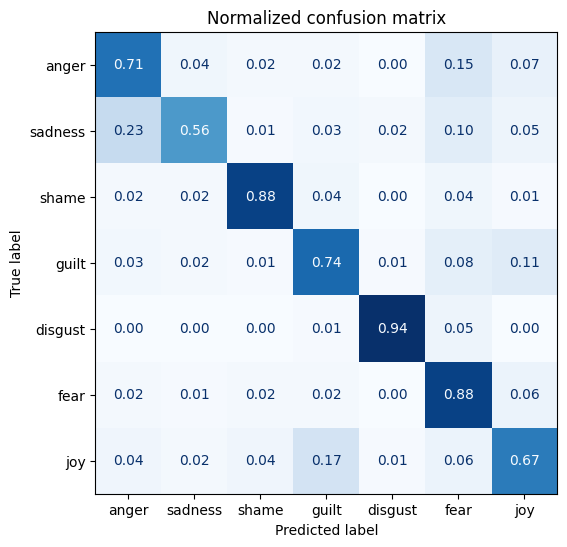

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,gemini-1.5-flash,Transfer Learning,0.769231,0.77957,0.768307,0.767287


In [14]:
# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    df_test["emotion"],
    df_test["predicted_emotion"],
    output_dict=True,
    target_names=df_test["emotion"].unique(),
)
print(
    classification_report(
        df_test["emotion"],
        df_test["predicted_emotion"],
        target_names=df_test["emotion"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": model_version,
        "Method": "Transfer Learning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)

# Convert results to a DataFrame
results_df_tl = pd.DataFrame(results)


plot_confusion_matrix(
    df_test["predicted_emotion"], df_test["emotion"], df_test["emotion"].unique()
)

results_df_tl

### `gemini-1.5-flash-latest`


In [15]:
model_version = "gemini-1.5-flash-latest"


system_message = """
You are an advanced assistant specialized in analyzing and detecting emotions in short text. 
You will be provided with a text, and your task is to classify it into **exactly one emotion** from the following list:
[shame, sadness, joy, guilt, fear, disgust, anger].

**Important Rules:**
1. You must return only **one** of the emotions from the list without aditional text.
2. Do **not** create or infer any emotions outside the list.
3. If the text does not match any emotion exactly, return the closest emotion from the list. 
4. Do not return aditional text, only **exactly one emotion** of the list.

For example:

Text: when the week for exams came I got afraid as to how I would tackle the questions.
Response: fear
"""

# Create the model
generation_config = {
    "temperature": 0,
    # "top_p": 0.95,
    # "top_k": 64,
    "max_output_tokens": 3,
    # "response_mime_type": "text/plain",
}

safety_config = {
    "HARASSMENT": "block_none",
    "HATE_SPEECH": "block_none",
    "HATE": "block_none",
    "SEXUALLY_EXPLICIT": "block_none",
    "DANGEROUS": "block_none",
}

model = genai.GenerativeModel(
    model_name=model_version,
    generation_config=generation_config,
    safety_settings=safety_config,
    system_instruction=system_message,
)


df_test["predicted_emotion"] = df_test["text"].apply(classify_emotion)
df_test.head()

,text,emotion,predicted_emotion
0,when a friend carelessly broke and object in m...,anger,anger
1,when i felt powerless to help the poor or when...,sadness,sadness
2,one of my best friends'fianct broke off the re...,shame,shame
3,i hadn't been at my parent's place for a long ...,sadness,sadness
4,when i didn't notify someone that he was summo...,guilt,guilt


Classification Report:
              precision    recall  f1-score   support

       anger       0.68      0.71      0.69       109
     sadness       0.85      0.56      0.67       107
       shame       0.91      0.88      0.89       109
       guilt       0.72      0.74      0.73       106
     disgust       0.96      0.94      0.95       109
        fear       0.65      0.88      0.75       108
         joy       0.69      0.67      0.68       106

    accuracy                           0.77       754
   macro avg       0.78      0.77      0.77       754
weighted avg       0.78      0.77      0.77       754



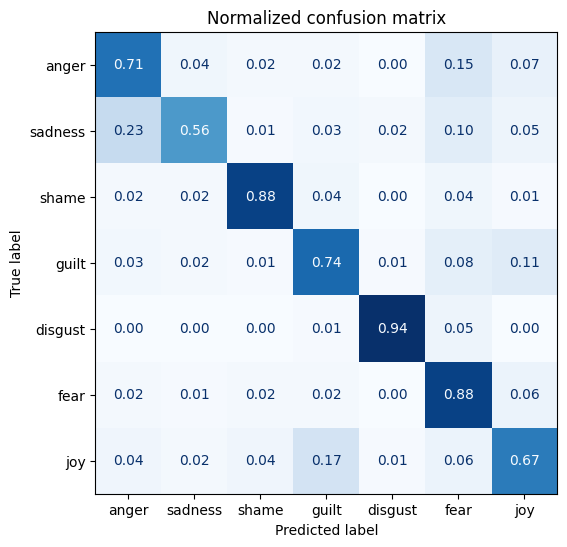

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,gemini-1.5-flash,Transfer Learning,0.769231,0.77957,0.768307,0.767287
0,gemini-1.5-flash-latest,Transfer Learning,0.769231,0.77957,0.768307,0.767287


In [16]:
# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    df_test["emotion"],
    df_test["predicted_emotion"],
    output_dict=True,
    target_names=df_test["emotion"].unique(),
)
print(
    classification_report(
        df_test["emotion"],
        df_test["predicted_emotion"],
        target_names=df_test["emotion"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": model_version,
        "Method": "Transfer Learning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)


plot_confusion_matrix(
    df_test["predicted_emotion"], df_test["emotion"], df_test["emotion"].unique()
)


results_df = pd.concat([results_df_tl, pd.DataFrame(results)])

results_df

### `gemini-1.5-pro-latest`


In [17]:
model_version = "gemini-1.5-pro-latest"


system_message = """
You are an advanced assistant specialized in analyzing and detecting emotions in short text. 
You will be provided with a text, and your task is to classify it into **exactly one emotion** from the following list:
[shame, sadness, joy, guilt, fear, disgust, anger].

**Important Rules:**
1. You must return only **one** of the emotions from the list without aditional text.
2. Do **not** create or infer any emotions outside the list.
3. If the text does not match any emotion exactly, return the closest emotion from the list. 
4. Do not return aditional text, only **exactly one emotion** of the list.

For example:

Text: when the week for exams came I got afraid as to how I would tackle the questions.
Response: fear
"""

# Create the model
generation_config = {
    "temperature": 0,
    # "top_p": 0.95,
    # "top_k": 64,
    "max_output_tokens": 3,
    # "response_mime_type": "text/plain",
}

safety_config = {
    "HARASSMENT": "block_none",
    "HATE_SPEECH": "block_none",
    "HATE": "block_none",
    "SEXUALLY_EXPLICIT": "block_none",
    "DANGEROUS": "block_none",
}

model = genai.GenerativeModel(
    model_name=model_version,
    generation_config=generation_config,
    safety_settings=safety_config,
    system_instruction=system_message,
)


df_test["predicted_emotion"] = df_test["text"].apply(classify_emotion)
df_test.head()

,text,emotion,predicted_emotion
0,when a friend carelessly broke and object in m...,anger,anger
1,when i felt powerless to help the poor or when...,sadness,sadness
2,one of my best friends'fianct broke off the re...,shame,shame
3,i hadn't been at my parent's place for a long ...,sadness,sadness
4,when i didn't notify someone that he was summo...,guilt,guilt


Classification Report:
              precision    recall  f1-score   support

       anger       0.66      0.60      0.62       109
     sadness       0.81      0.56      0.66       107
       shame       0.82      0.90      0.86       109
       guilt       0.78      0.75      0.76       106
     disgust       0.96      0.99      0.97       109
        fear       0.64      0.90      0.75       108
         joy       0.75      0.69      0.72       106

    accuracy                           0.77       754
   macro avg       0.77      0.77      0.76       754
weighted avg       0.77      0.77      0.77       754



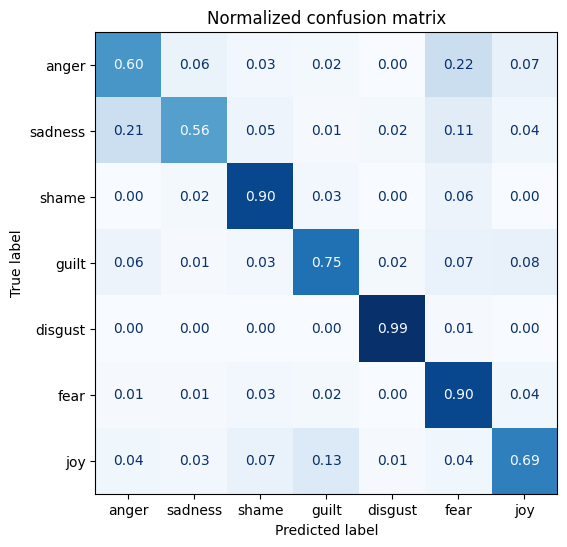

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,gemini-1.5-flash,Transfer Learning,0.769231,0.779570,0.768307,0.767287
0,gemini-1.5-flash-latest,Transfer Learning,0.769231,0.779570,0.768307,0.767287
0,gemini-1.5-pro-latest,Transfer Learning,0.769231,0.774828,0.768442,0.764591


In [18]:
# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    df_test["emotion"],
    df_test["predicted_emotion"],
    output_dict=True,
    target_names=df_test["emotion"].unique(),
)
print(
    classification_report(
        df_test["emotion"],
        df_test["predicted_emotion"],
        target_names=df_test["emotion"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": model_version,
        "Method": "Transfer Learning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)


plot_confusion_matrix(
    df_test["predicted_emotion"], df_test["emotion"], df_test["emotion"].unique()
)


results_df = pd.concat([results_df, pd.DataFrame(results)])

results_df

## Fine tuning


### Preparing Data

De acuerdo a la dofumentación de https://ai.google.dev/gemini-api/docs/model-tuning?hl=es-419, La data tiene que estar en un formato específico para poder ser usado por el modelo en el proceso de fine-tuning:

data = [
{"text_input": "some input", "output": "expected output"},
{"text_input": "some input", "output": "expected output"},
...
]


In [19]:
# Function to transform DataFrame into desired format
def prepare_finetuning_data(df):
    return df.apply(
        lambda row: {"text_input": row["text"], "output": row["emotion"]}, axis=1
    ).tolist()


# Apply the function to dfs
df_train = pd.concat([df_train, df_val])

train_data = prepare_finetuning_data(df_train)
test_data = prepare_finetuning_data(df_test)


train_data[:3]

[{'text_input': 'when the week for exams came i got afraid as to how i would tackle the questions',
  'output': 'fear'},
 {'text_input': "i was sleeping when i heard the neighbours screaming, i peeped through the window and saw a thief  trying to enter my neighbour's house",
  'output': 'fear'},
 {'text_input': 'there was a time when my room looked terribly untidy; just at that time my aunt came to see me; fortunately i could prevent her from entering the room',
  'output': 'shame'}]

### Model Fine-tuniung

Los modelos disponibles al momento de este desarrollo son los siguientes:


In [20]:
models_to_tuning = [
    m
    for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods
]

print(f"There are {len(models_to_tuning)} models to tuning")
models_to_tuning

There are 2 models to tuning


[Model(name='models/gemini-1.0-pro-001',
       base_model_id='',
       version='001',
       display_name='Gemini 1.0 Pro 001 (Tuning)',
       description=('The best model for scaling across a wide range of tasks. This is a stable '
                    'model that supports tuning.'),
       input_token_limit=30720,
       output_token_limit=2048,
       supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
       temperature=0.9,
       max_temperature=None,
       top_p=1.0,
       top_k=None),
 Model(name='models/gemini-1.5-flash-001-tuning',
       base_model_id='',
       version='001',
       display_name='Gemini 1.5 Flash 001 Tuning',
       description='Fast and versatile multimodal model for scaling across diverse tasks',
       input_token_limit=16384,
       output_token_limit=8192,
       supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
       temperature=1.0,
       max_temperature=2.0,
       top_p=0.95,

### Model `gemini-1.5-flash-001-tuning` 5 epochs


  0%|          | 0/530 [00:00<?, ?it/s]

TunedModel(name='tunedModels/gemini15flashfinetunedisear5e-jxuaj2dew0',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='gemini-1.5-flash-fine-tuned-isear-5e',
           description='',
           temperature=0.0,
           top_p=0.95,
           top_k=64,
           state=<State.ACTIVE: 2>,
           create_time=datetime.datetime(2024, 10, 29, 13, 5, 54, 683214, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 10, 29, 16, 0, 29, 243481, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2024, 10, 29, 13, 5, 55, 331591, tzinfo=datetime.timezone.utc),
                                  complete_time=datetime.datetime(2024, 10, 29, 16, 0, 29, 243481, tzinfo=datetime.timezone.utc),
                                  snapshots=[...],
                                  hyperparameters=Hyperparameters(epoch_count=5,
        

<Axes: xlabel='epoch', ylabel='mean_loss'>

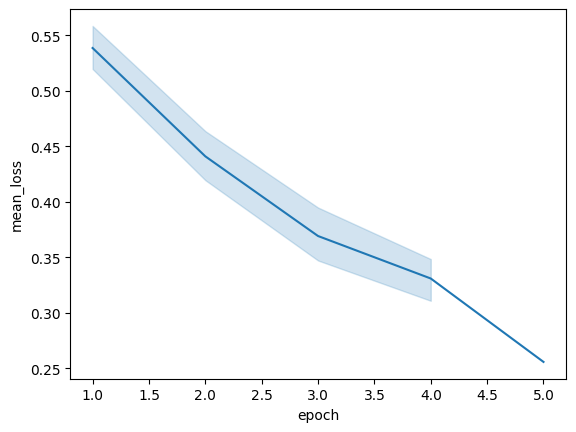

In [21]:
import time

base_model = "models/gemini-1.5-flash-001-tuning"

operation = genai.create_tuned_model(
    display_name="gemini-1.5-flash-fine-tuned-isear-5e",
    source_model=base_model,
    temperature=0,
    epoch_count=5,
    batch_size=64,
    learning_rate=0.001,
    training_data=train_data,
)

for status in operation.wait_bar():
    time.sleep(10)

result = operation.result()
print(result)
# # You can plot the loss curve with:
snapshots = pd.DataFrame(result.tuning_task.snapshots)
sns.lineplot(data=snapshots, x="epoch", y="mean_loss")

#### Evaluate fine-tuned model


In [22]:
# Testinf fine tunned model

model_version = "tunedModels/gemini15flashfinetunedisear5e-jxuaj2dew0"


# Create the model
generation_config = {
    "temperature": 0,
    # "top_p": 0.95,
    # "top_k": 64,
    "max_output_tokens": 3,
    # "response_mime_type": "text/plain",
}

safety_config = {
    "HARASSMENT": "block_none",
    "HATE_SPEECH": "block_none",
    "HATE": "block_none",
    "SEXUALLY_EXPLICIT": "block_none",
    "DANGEROUS": "block_none",
    "SEXUAL": "block_none",
}

model = genai.GenerativeModel(
    model_name=model_version,
    generation_config=generation_config,
    safety_settings=safety_config,
    # system_instruction=system_message,
)


df_test["predicted_emotion"] = df_test["text"].apply(classify_emotion)


Error processing text: the mother of a friend of mine passed by me and saw me sitting on a boy's lap  i tried to greet her but could not help blushing
Error: Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER

Error processing text: the first time that i caressed a girl, i was about thirteen and she was eighteen  i noticed that it did not affect her at all
Error: Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.
This appears to be caused by a blocked prompt, see `response.prompt_feedback`: block_reason: OTHER

Error processing text: when my red-cheeked, content child runs to meet me in the yard of the kindergarten and gives me a moist kiss on my cheek
Error: Invalid operation: The `response.parts` quick accessor requires a single candidate, but

In [23]:
df_test[df_test["predicted_emotion"] == "unknown"]

,text,emotion,predicted_emotion
245,the mother of a friend of mine passed by me an...,shame,unknown
354,"the first time that i caressed a girl, i was a...",shame,unknown
400,"when my red-cheeked, content child runs to mee...",joy,unknown


Hay 3 observaciones que se no superaron los filtros de seguridad, al parecer, por una categoría que no está cubierta en la documentación de `safety_config`. Por lo tanto, se eliminan estas 3 observaciones de la muestra de test.


In [24]:
df_test = df_test[df_test["predicted_emotion"] != "unknown"]

Classification Report:
              precision    recall  f1-score   support

       anger       0.64      0.83      0.72       109
     sadness       0.82      0.70      0.76       107
       shame       0.91      0.85      0.88       109
       guilt       0.73      0.62      0.67       106
     disgust       0.99      0.95      0.97       108
        fear       0.81      0.80      0.80       108
         joy       0.60      0.67      0.64       104

    accuracy                           0.78       751
   macro avg       0.79      0.78      0.78       751
weighted avg       0.79      0.78      0.78       751



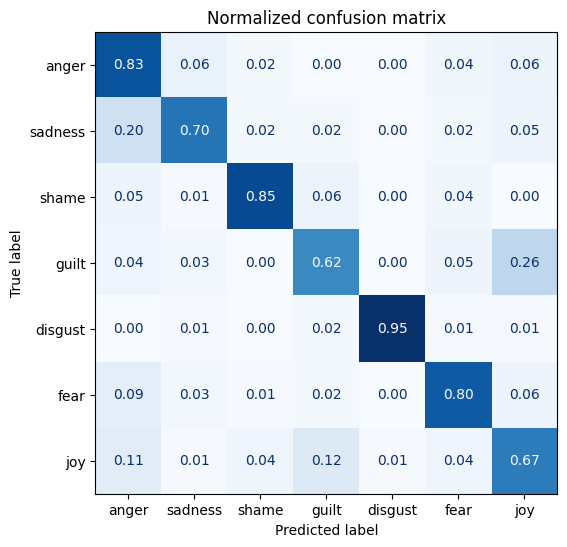

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,gemini-1.5-flash,Transfer Learning,0.769231,0.779570,0.768307,0.767287
0,gemini-1.5-flash-latest,Transfer Learning,0.769231,0.779570,0.768307,0.767287
0,gemini-1.5-pro-latest,Transfer Learning,0.769231,0.774828,0.768442,0.764591
0,tunedModels/gemini15flashfinetunedisear5e-jxua...,Fine-Tuning,0.776298,0.786381,0.775079,0.777278


In [25]:
# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    df_test["emotion"],
    df_test["predicted_emotion"],
    output_dict=True,
    target_names=df_test["emotion"].unique(),
)
print(
    classification_report(
        df_test["emotion"],
        df_test["predicted_emotion"],
        target_names=df_test["emotion"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": model_version,
        "Method": "Fine-Tuning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)


plot_confusion_matrix(
    df_test["predicted_emotion"], df_test["emotion"], df_test["emotion"].unique()
)


results_df = pd.concat([results_df, pd.DataFrame(results)])

results_df

### Model `gemini-1.5-flash-001-tuning` 15 epochs


  0%|          | 0/1590 [00:00<?, ?it/s]

TunedModel(name='tunedModels/gemini15flashfinetunedisear15e-6iy7j0f1u',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='gemini-1.5-flash-fine-tuned-isear-15e',
           description='',
           temperature=0.0,
           top_p=0.95,
           top_k=64,
           state=<State.ACTIVE: 2>,
           create_time=datetime.datetime(2024, 10, 29, 16, 27, 49, 924314, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 10, 30, 0, 56, 51, 634475, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2024, 10, 29, 16, 27, 50, 532769, tzinfo=datetime.timezone.utc),
                                  complete_time=datetime.datetime(2024, 10, 30, 0, 56, 51, 634475, tzinfo=datetime.timezone.utc),
                                  snapshots=[...],
                                  hyperparameters=Hyperparameters(epoch_count=15,
    

<Axes: xlabel='epoch', ylabel='mean_loss'>

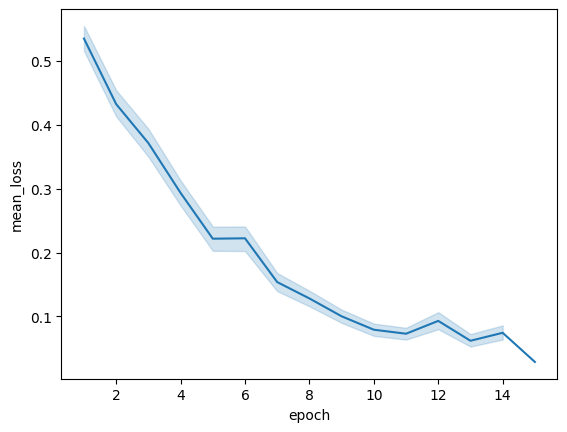

In [26]:
base_model = "models/gemini-1.5-flash-001-tuning"

operation = genai.create_tuned_model(
    display_name="gemini-1.5-flash-fine-tuned-isear-15e",
    source_model=base_model,
    temperature=0,
    epoch_count=15,
    batch_size=64,
    learning_rate=0.001,
    training_data=train_data,
)

for status in operation.wait_bar():
    time.sleep(10)

result = operation.result()
print(result)
# # You can plot the loss curve with:
snapshots = pd.DataFrame(result.tuning_task.snapshots)
sns.lineplot(data=snapshots, x="epoch", y="mean_loss")

#### Evaluate fine-tuned model


In [27]:
# Testinf fine tunned model

model_version = "tunedModels/gemini15flashfinetunedisear15e-6iy7j0f1u"


# Create the model
generation_config = {
    "temperature": 0,
    # "top_p": 0.95,
    # "top_k": 64,
    "max_output_tokens": 3,
    # "response_mime_type": "text/plain",
}

safety_config = {
    "HARASSMENT": "block_none",
    "HATE_SPEECH": "block_none",
    "HATE": "block_none",
    "SEXUALLY_EXPLICIT": "block_none",
    "DANGEROUS": "block_none",
    "SEXUAL": "block_none",
}

model = genai.GenerativeModel(
    model_name=model_version,
    generation_config=generation_config,
    safety_settings=safety_config,
    # system_instruction=system_message,
)


df_test["predicted_emotion"] = df_test["text"].apply(classify_emotion)


In [28]:
df_test.predicted_emotion.unique()

array(['anger', 'sadness', 'shame', 'guilt', 'disgust', 'fear',
       'sadnesssad', 'disgustdis', 'shameshame', 'joy', 'angeranger',
       'disgustanger', 'joyjoy', 'shameguilt', 'guiltgu'], dtype=object)

In [29]:
# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    df_test["emotion"],
    df_test["predicted_emotion"],
    output_dict=True,
    target_names=df_test["emotion"].unique(),
)
print(
    classification_report(
        df_test["emotion"],
        df_test["predicted_emotion"],
        target_names=df_test["emotion"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": model_version,
        "Method": "Fine-Tuning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)


plot_confusion_matrix(
    df_test["predicted_emotion"], df_test["emotion"], df_test["emotion"].unique()
)


results_df = pd.concat([results_df, pd.DataFrame(results)])

results_df

Classification Report:


ValueError: Number of classes, 15, does not match size of target_names, 7. Try specifying the labels parameter

##### **CON MÁS EPOCAS EL MODELO PREDICE MÁS DE LAS ETIQUETAS POSIBLES**


### Probando otro modelo finetuneado


In [32]:
# Testinf fine tunned model

model_version = "tunedModels/gemini15flashfinetunedisear-2ssoh15ski2w"


# Create the model
generation_config = {
    "temperature": 0,
    # "top_p": 0.95,
    # "top_k": 64,
    "max_output_tokens": 3,
    # "response_mime_type": "text/plain",
}

safety_config = {
    "HARASSMENT": "block_none",
    "HATE_SPEECH": "block_none",
    "HATE": "block_none",
    "SEXUALLY_EXPLICIT": "block_none",
    "DANGEROUS": "block_none",
    "SEXUAL": "block_none",
}

model = genai.GenerativeModel(
    model_name=model_version,
    generation_config=generation_config,
    safety_settings=safety_config,
    # system_instruction=system_message,
)


df_test["predicted_emotion"] = df_test["text"].apply(classify_emotion)


Classification Report:
              precision    recall  f1-score   support

       anger       0.69      0.77      0.73       109
     sadness       0.77      0.76      0.76       107
       shame       0.94      0.84      0.89       109
       guilt       0.74      0.79      0.76       106
     disgust       0.96      0.97      0.97       108
        fear       0.85      0.72      0.78       108
         joy       0.65      0.70      0.68       104

    accuracy                           0.79       751
   macro avg       0.80      0.79      0.80       751
weighted avg       0.80      0.79      0.80       751



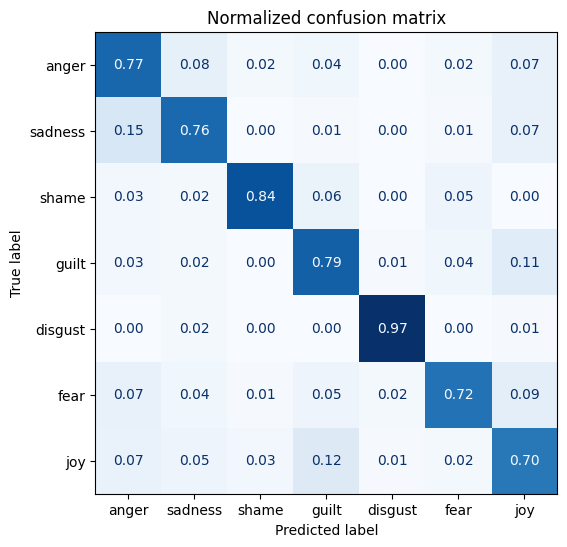

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,gemini-1.5-flash,Transfer Learning,0.769231,0.779570,0.768307,0.767287
0,gemini-1.5-flash-latest,Transfer Learning,0.769231,0.779570,0.768307,0.767287
0,gemini-1.5-pro-latest,Transfer Learning,0.769231,0.774828,0.768442,0.764591
0,tunedModels/gemini15flashfinetunedisear5e-jxua...,Fine-Tuning,0.776298,0.786381,0.775079,0.777278
0,tunedModels/gemini15flashfinetunedisear-2ssoh1...,Fine-Tuning,0.794940,0.800597,0.794358,0.795826


In [33]:
# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    df_test["emotion"],
    df_test["predicted_emotion"],
    output_dict=True,
    target_names=df_test["emotion"].unique(),
)
print(
    classification_report(
        df_test["emotion"],
        df_test["predicted_emotion"],
        target_names=df_test["emotion"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": model_version + "_v2",
        "Method": "Fine-Tuning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)


plot_confusion_matrix(
    df_test["predicted_emotion"], df_test["emotion"], df_test["emotion"].unique()
)


results_df = pd.concat([results_df, pd.DataFrame(results)])

results_df

In [34]:
results_df.to_excel("../data/model_results/llm_gemini.xlsx", index=False)

In [30]:
for i, m in zip(range(5), genai.list_tuned_models()):
    print(m.name)

tunedModels/gemini15flashfinetunedisear-2ssoh15ski2w
tunedModels/gemini15flashfinetunedisear15e-hoagjbin9
tunedModels/gemini15flashfinetunedisear5e-jxuaj2dew0
tunedModels/gemini15flashfinetunedisear15e-6iy7j0f1u
